# Install Packages

In [1]:
#https://data.jrc.ec.europa.eu/dataset/9d57494f-fd53-4ff0-8c4c-4606fc2c6d81

In [2]:
#!pip install pandas imageio numpy rasterio geopandas cartopy matplotlib


In [3]:
# --- System and file handling ---
import os
import pandas as pd
import imageio

# --- Numerical and array operations ---
import numpy as np

# --- Raster handling ---
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds

# --- Geo-spatial handling ---
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Plotting ---
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm

# Load Data

In [4]:
# --- Path to SPEI raster data ---
data_dir = 'spei12'

# --- Find all folders starting with 'sem01' ---
folders = [
    f for f in os.listdir(data_dir) 
    if f.startswith('spe12') and os.path.isdir(os.path.join(data_dir, f))
]

records = []

# --- Loop through folders and load all .tif files ---
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.tif'):
            file_path = os.path.join(folder_path, file)
            with rasterio.open(file_path) as src:
                img = src.read(1)  # Read the first band
                records.append({
                    'folder': folder,
                    'file': file,
                    'data': img
                })

# --- Create a DataFrame with all rasters ---
df_tiffs = pd.DataFrame(records)


In [5]:
df_tiffs.head()

,folder,file,data
0,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910101_m_100_z01.tif,"[[0.7607253789901733, 0.7597334980964661, 0.75..."
1,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910201_m_100_z01.tif,"[[0.18390393257141113, 0.18283021450042725, 0...."
2,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910301_m_100_z01.tif,"[[-0.21941615641117096, -0.22050268948078156, ..."
3,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910401_m_100_z01.tif,"[[-0.46714165806770325, -0.46814072132110596, ..."
4,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910501_m_100_z01.tif,"[[-1.2275904417037964, -1.2276045083999634, -1..."


# Plot Only Data

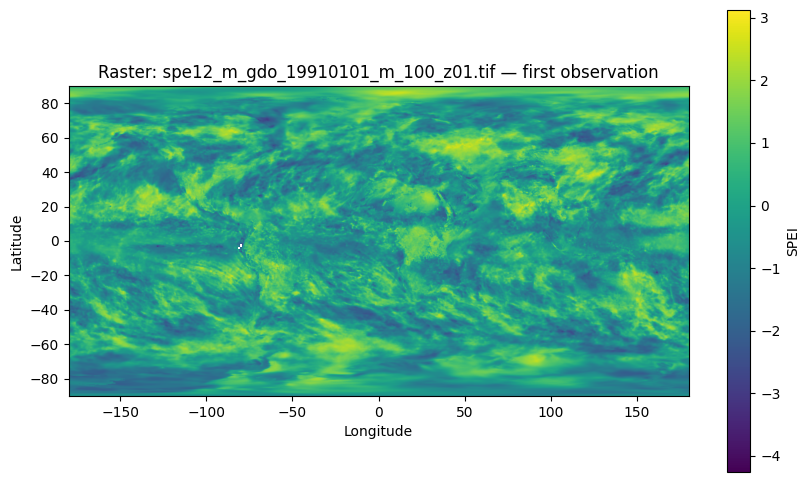

Raster geographic bounds (minx, maxx, miny, maxy): [-180.0, 180.0, -90.0, 90.0]


In [6]:
# --- Pick the first raster observation ---
first_row = df_tiffs.iloc[0]
img = first_row['data']
folder = first_row['folder']
file = first_row['file']
file_path = os.path.join('spei12', folder, file)

# --- Reopen raster to get transform and CRS ---
with rasterio.open(file_path) as src:
    transform = src.transform
    crs = src.crs
    # Compute geographic bounds
    h, w = src.height, src.width
    minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
    extent = [minx, maxx, miny, maxy]

# --- Mask invalid values ---
masked = np.ma.masked_invalid(img)

# --- Plot raster ---
plt.figure(figsize=(10, 6))
plt.imshow(masked, origin='upper', extent=extent, cmap='viridis')
plt.colorbar(label='SPEI')
plt.title(f"Raster: {file} — first observation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# --- Print raster extent info ---
print("Raster geographic bounds (minx, maxx, miny, maxy):", extent)


In [7]:
from matplotlib import colormaps  # <- new API

# --- Colormap and normalization ---
cmap_name = 'RdBu_r'
cmap = colormaps[cmap_name].copy()   # replace cm.get_cmap()
cmap.set_bad(color='lightgray')      # NaNs appear gray

bounds = np.linspace(-3, 3, 13)
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# Pick a raster file
row = df_tiffs.iloc[0]
file_path = os.path.join('spei12', row['folder'], row['file'])

# Reopen the tif to get affine transform/crs
with rasterio.open(file_path) as src:
    img = src.read(1)
    transform = src.transform
    crs = src.crs

# Mask invalid values (NaNs)
masked = np.ma.masked_invalid(img)

# Compute raster extent
h, w = img.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
extent = [minx, maxx, miny, maxy]

# Use raster CRS (EPSG:3035) for correct alignment
img_crs = ccrs.epsg(3035)

In [8]:
# extract the 8-digit date string from the filename (e.g. '20000101')
df_tiffs['date'] = df_tiffs['file'].str.extract(r'(\d{8})', expand=False)
df_tiffs['date'] = pd.to_datetime(df_tiffs['date'], format='%Y%m%d').dt.date  # remove time component
df_tiffs.head()

,folder,file,data,date
0,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910101_m_100_z01.tif,"[[0.7607253789901733, 0.7597334980964661, 0.75...",1991-01-01
1,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910201_m_100_z01.tif,"[[0.18390393257141113, 0.18283021450042725, 0....",1991-02-01
2,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910301_m_100_z01.tif,"[[-0.21941615641117096, -0.22050268948078156, ...",1991-03-01
3,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910401_m_100_z01.tif,"[[-0.46714165806770325, -0.46814072132110596, ...",1991-04-01
4,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910501_m_100_z01.tif,"[[-1.2275904417037964, -1.2276045083999634, -1...",1991-05-01


# Plot over Armenia

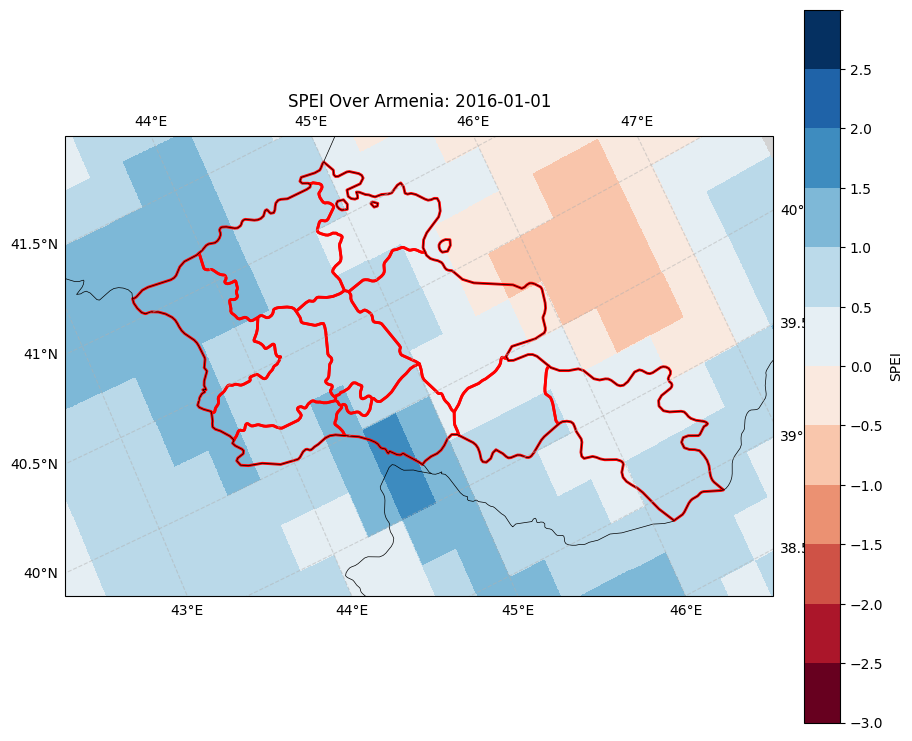

In [9]:
import os
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds  # <-- added
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib import colormaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Colormap setup ---
cmap_name = 'RdBu_r'
cmap = colormaps[cmap_name].reversed().copy()
cmap.set_bad(color='lightgray')
bounds = np.linspace(-3, 3, 13)
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# --- Pick the first raster ---
row = df_tiffs.iloc[300]
file_path = os.path.join('spei12', row['folder'], row['file'])

# --- Armenia bounding box in EPSG:3035 ---
armenia_bounds = [7000000, 7400000, 2450000, 2710000]  # minx, maxx, miny, maxy

# --- Open raster and crop to Armenia ---
with rasterio.open(file_path) as src:
    raster_bounds = src.bounds

    # Transform Armenia bbox into raster CRS (minimal change)
    arm_transformed = transform_bounds(
        'EPSG:3035',  # source CRS of armenia_bounds
        src.crs,      # destination CRS (raster CRS)
        armenia_bounds[0], armenia_bounds[2], armenia_bounds[1], armenia_bounds[3],
        densify_pts=21
    )

    # Intersect with raster bounds
    minx = max(raster_bounds.left, arm_transformed[0])
    maxx = min(raster_bounds.right, arm_transformed[2])
    miny = max(raster_bounds.bottom, arm_transformed[1])
    maxy = min(raster_bounds.top, arm_transformed[3])

    window = from_bounds(minx, miny, maxx, maxy, transform=src.transform)
    img_cropped = src.read(1, window=window)
    transform_cropped = src.window_transform(window)
    crs = src.crs

# Mask invalid values
masked_cropped = np.ma.masked_invalid(img_cropped)

# Compute correct extent for imshow
h, w = img_cropped.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform_cropped)
extent_cropped = [minx, maxx, miny, maxy]

# --- Load Armenia first-level borders ---
districts_fp = 'armenia_shapefile/am.json'
districts = gpd.read_file(districts_fp).to_crs(epsg=3035)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.epsg(3035)})

armenia_bounds_3035 = [7000000, 7400000, 2450000, 2710000]
ax.set_extent(armenia_bounds_3035, crs=ccrs.epsg(3035))

# Use raster CRS for transform in imshow
if crs.is_geographic:
    img_transform_crs = ccrs.PlateCarree()
else:
    img_transform_crs = ccrs.epsg(int(crs.to_epsg()))

im = ax.imshow(masked_cropped, origin='upper', extent=extent_cropped,
               transform=img_transform_crs, cmap=cmap, norm=norm)

# Overlay first-level borders
ax.add_geometries(districts.geometry, crs=ccrs.epsg(3035), facecolor='none', edgecolor='red', linewidth=2)

# Optional Cartopy features
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=bounds[:-1])
cbar.set_label('SPEI')

ax.set_title(f"SPEI Over Armenia: {row['date']}")
plt.show()


In [10]:
extent_cropped

[42.25076955448307, 47.75076955448307, 38.24460539601576, 41.99460539601576]

# Begin time series

In [11]:
# Keep only January 1st observations

_dates = pd.to_datetime(df_tiffs['date'], errors='coerce')
mask = (_dates.dt.month == 1) & (_dates.dt.day == 1)

df_tiffs = df_tiffs.loc[mask].copy().reset_index(drop=True)
df_tiffs['date'] = pd.to_datetime(df_tiffs['date']).dt.date  # ensure date column is date objects

print(f"Kept {len(df_tiffs)} observations (01-01).")
df_tiffs.head()

df_tiffs['year'] = pd.to_datetime(df_tiffs['date']).dt.year
df_tiffs.head()

Kept 35 observations (01-01).


,folder,file,data,date,year
0,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910101_m_100_z01.tif,"[[0.7607253789901733, 0.7597334980964661, 0.75...",1991-01-01,1991
1,spe12_m_gdo_19920101_19921201_m,spe12_m_gdo_19920101_m_100_z01.tif,"[[0.4168041944503784, 0.41690152883529663, 0.4...",1992-01-01,1992
2,spe12_m_gdo_19930101_19931201_m,spe12_m_gdo_19930101_m_100_z01.tif,"[[1.610102653503418, 1.6098918914794922, 1.609...",1993-01-01,1993
3,spe12_m_gdo_19940101_19941201_m,spe12_m_gdo_19940101_m_100_z01.tif,"[[-1.7837190628051758, -1.78331458568573, -1.7...",1994-01-01,1994
4,spe12_m_gdo_19950101_19951201_m,spe12_m_gdo_19950101_m_100_z01.tif,"[[0.027685359120368958, 0.02723712846636772, 0...",1995-01-01,1995


In [12]:
# shift year back by 1 (e.g., 1991 -> 1990)
df_tiffs['year'] = pd.to_datetime(df_tiffs['date']).dt.year - 1

# quick check
print(df_tiffs[['date', 'year']].head())

         date  year
0  1991-01-01  1990
1  1992-01-01  1991
2  1993-01-01  1992
3  1994-01-01  1993
4  1995-01-01  1994


# Now extract per distict mean values

In [13]:
from rasterio.features import rasterize

# For each observation compute mean SPEI for each Armenia district (pixels that are inside OR touching a district)


records = []

for _, row in df_tiffs.iterrows():
    fp = os.path.join('spei12', row['folder'], row['file'])
    with rasterio.open(fp) as src:
        arr = src.read(1).astype('float32')
        # mark nodata as nan
        if src.nodata is not None:
            arr[arr == src.nodata] = np.nan

        h, w = src.height, src.width
        transform = src.transform
        src_crs = src.crs

        # reproject districts to raster CRS
        districts_in_raster_crs = districts.to_crs(src_crs)

        # Create an integer mapping for district identifiers (original ids may be strings like 'AMTV')
        # Use a stable ordering from the GeoDataFrame
        orig_ids = districts_in_raster_crs['id'].astype(str).tolist()
        name_list = districts_in_raster_crs['name'].tolist()
        id_map = {orig_id: i + 1 for i, orig_id in enumerate(orig_ids)}       # map original id -> integer
        name_map = {i + 1: name for i, name in enumerate(name_list)}         # map integer -> name

        # prepare shapes as (geometry, integer_district_id)
        shapes = ((geom, id_map[str(did)]) for did, geom in zip(districts_in_raster_crs['id'], districts_in_raster_crs.geometry))

        # rasterize districts: all_touched=True includes pixels touching the polygon boundary
        rasterized = rasterize(
            shapes=shapes,
            out_shape=(h, w),
            transform=transform,
            fill=0,
            all_touched=True,
            dtype='int32'
        )

        # compute mean per district
        unique_ids = np.unique(rasterized)
        unique_ids = unique_ids[unique_ids != 0]  # drop background

        for did in unique_ids:
            mask = rasterized == int(did)
            if not mask.any():
                mean_val = np.nan
            else:
                mean_val = np.nanmean(arr[mask])
            # find district name using the integer->name map
            name = name_map.get(int(did), None)
            records.append({
                'date': row.get('date'),
                'year': row.get('year'),
                'folder': row['folder'],
                'file': row['file'],
                'district_id': int(did),
                'district_name': name,
                'mean_spei': float(mean_val) if not np.isnan(mean_val) else np.nan
            })

# Results: long format (one row per observation x district)
df_district_means = pd.DataFrame(records)

# Optional: wide pivot (dates x districts)
df_district_means_wide = df_district_means.pivot_table(
    index='date',
    columns='district_name',
    values='mean_spei'
)

# show a snippet
print(df_district_means.head())

         date  year                           folder  \
0  1991-01-01  1990  spe12_m_gdo_19910101_19911201_m   
1  1991-01-01  1990  spe12_m_gdo_19910101_19911201_m   
2  1991-01-01  1990  spe12_m_gdo_19910101_19911201_m   
3  1991-01-01  1990  spe12_m_gdo_19910101_19911201_m   
4  1991-01-01  1990  spe12_m_gdo_19910101_19911201_m   

                                 file  district_id district_name  mean_spei  
0  spe12_m_gdo_19910101_m_100_z01.tif            1        Tavush   0.485895  
1  spe12_m_gdo_19910101_m_100_z01.tif            2          Lori   0.365838  
2  spe12_m_gdo_19910101_m_100_z01.tif            3        Shirak   0.396721  
3  spe12_m_gdo_19910101_m_100_z01.tif            4   Gegharkunik   0.039193  
4  spe12_m_gdo_19910101_m_100_z01.tif            5   Vayots Dzor  -0.229325  


In [14]:
districts

,source,id,name,geometry
0,https://simplemaps.com,AMTV,Tavush,"POLYGON ((7203266.349 2644370.051, 7203244.363..."
1,https://simplemaps.com,AMLO,Lori,"POLYGON ((7138122.849 2682736.564, 7138131.707..."
2,https://simplemaps.com,AMSH,Shirak,"POLYGON ((7075691.146 2643801.957, 7075738.783..."
3,https://simplemaps.com,AMGR,Gegharkunik,"MULTIPOLYGON (((7160257.024 2622014.037, 71682..."
4,https://simplemaps.com,AMVD,Vayots Dzor,"POLYGON ((7219728.476 2554017.188, 7222228.581..."
5,https://simplemaps.com,AMSU,Syunik,"POLYGON ((7278770.201 2547288.943, 7278746.539..."
6,https://simplemaps.com,AMAR,Ararat,"POLYGON ((7200075.703 2581289.958, 7201019.514..."
7,https://simplemaps.com,AMAG,Aragatsotn,"POLYGON ((7108879.041 2607378.723, 7109757.404..."
8,https://simplemaps.com,AMAV,Armavir,"POLYGON ((7156056.199 2557640.946, 7156270.391..."
9,https://simplemaps.com,AMKT,Kotayk,"POLYGON ((7157764.165 2622635.1, 7160257.024 2..."


In [15]:
df_district_means

,date,year,folder,file,district_id,district_name,mean_spei
0,1991-01-01,1990,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910101_m_100_z01.tif,1,Tavush,0.485895
1,1991-01-01,1990,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910101_m_100_z01.tif,2,Lori,0.365838
2,1991-01-01,1990,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910101_m_100_z01.tif,3,Shirak,0.396721
3,1991-01-01,1990,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910101_m_100_z01.tif,4,Gegharkunik,0.039193
4,1991-01-01,1990,spe12_m_gdo_19910101_19911201_m,spe12_m_gdo_19910101_m_100_z01.tif,5,Vayots Dzor,-0.229325
...,...,...,...,...,...,...,...
380,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,7,Ararat,-0.491594
381,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,8,Aragatsotn,-0.038781
382,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,9,Armavir,-0.376486
383,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,10,Kotayk,0.226452


In [16]:
# Preview existing district names so you can build the mapping
print("Before rename:", sorted(df_district_means['district_name'].unique()))

# Define the rename mapping: replace keys with desired new names
rename_map = {
    # example mappings — replace these with the actual names you want to change
    'Gegharkunik': 'Gegharkunik', #still change
    'Erevan': 'Yerevan',
    # add more mappings as needed
}

# Apply renaming
df_district_means['district_name'] = df_district_means['district_name'].replace(rename_map)

# Rebuild the wide pivot (if you need the wide table updated)
df_district_means_wide = df_district_means.pivot_table(
    index='date',
    columns='district_name',
    values='mean_spei'
)

# Confirm results
print("After rename:", sorted(df_district_means['district_name'].unique()))

Before rename: ['Aragatsotn', 'Ararat', 'Armavir', 'Erevan', 'Gegharkunik', 'Kotayk', 'Lori', 'Shirak', 'Syunik', 'Tavush', 'Vayots Dzor']
After rename: ['Aragatsotn', 'Ararat', 'Armavir', 'Gegharkunik', 'Kotayk', 'Lori', 'Shirak', 'Syunik', 'Tavush', 'Vayots Dzor', 'Yerevan']


In [17]:
df_district_means.to_csv('armenia_yearly_spei_mean.csv', index=False)